In [1]:
# !pip install hmmlearn

     |████████████████████████████████| 120 kB 2.0 MB/s eta 0:00:01


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
%matplotlib inline

In [3]:
# load the open sp500 open price information
stock = pd.read_csv('Daily.csv')
stock = stock.set_index('Date')
stock = stock.astype('float64')
stock.head()

,SP500
Date,
3/2/2015 16:00,2105.23
3/3/2015 16:00,2115.76
3/4/2015 16:00,2107.72
3/5/2015 16:00,2098.54
3/6/2015 16:00,2100.91


In [5]:
# we generate the dates vector
dates = pd.to_datetime(stock.index[1:])
print(len(dates))

1257


In [6]:
# we generate the open price vector
prices =  stock[1:]
print(len(prices))

1257


In [9]:
stock[1:]

,SP500
Date,
3/3/2015 16:00,2115.76
3/4/2015 16:00,2107.72
3/5/2015 16:00,2098.54
3/6/2015 16:00,2100.91
3/9/2015 16:00,2072.25
...,...
2/21/2020 16:00,3360.50
2/24/2020 16:00,3257.61
2/25/2020 16:00,3238.94


In [10]:
stock[:-1]

,SP500
Date,
3/2/2015 16:00,2105.23
3/3/2015 16:00,2115.76
3/4/2015 16:00,2107.72
3/5/2015 16:00,2098.54
3/6/2015 16:00,2100.91
...,...
2/20/2020 16:00,3380.45
2/21/2020 16:00,3360.50
2/24/2020 16:00,3257.61


In [7]:
# we generate the 1-day log return vector
log_returns = (np.log(np.array(stock[1:]))-np.log(np.array(stock[:-1])))
print(np.size(log_returns))

1257


In [8]:
log_returns

array([[ 0.00498936],
       [-0.00380729],
       [-0.00436493],
       ...,
       [-0.00574768],
       [-0.03105516],
       [-0.02494632]])

In [7]:
# using HMM model to obtian the hidden states of SP500 index
hmm = GaussianHMM(n_components = 2, covariance_type='diag',n_iter = 5000).fit(log_returns)
hidden_states = hmm.predict(log_returns)
print(hidden_states)

[0 0 0 ... 1 1 1]


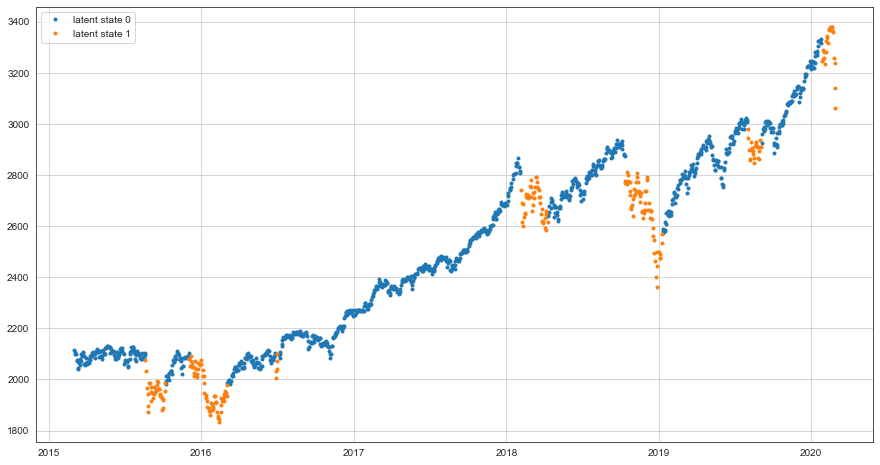

In [8]:
# plot the states of SP500 over time
sns.set_style('white')
plt.figure(figsize = (15, 8))
for i in range(hmm.n_components):
    state = (hidden_states == i)
    plt.plot(dates[state],prices[state],'.',label = 'latent state %d'%i,lw = 1)
    plt.legend()
    plt.grid(1)

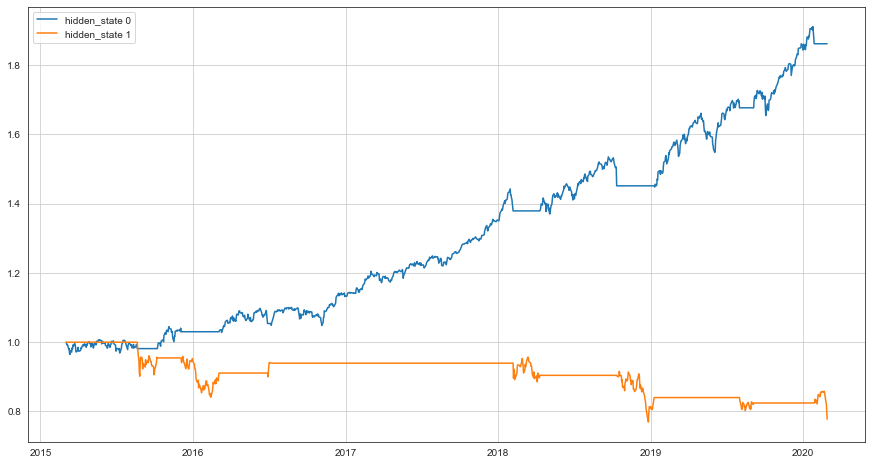

In [9]:
# we accumulate the P/L for each hidden states, and it's obvious that state 0  in increasing and state 1 is decreasing
sp500 = pd.DataFrame({'date':dates, 'log_return':np.ravel(log_returns), 'state':hidden_states}).set_index('date')
plt.figure(figsize=(15,8))
for i in range(hmm.n_components):
    state = (hidden_states  == i)
    idx = np.append(0,state[:-1])
    sp500['state %d_return'%i] = sp500.log_return.multiply(idx,axis = 0) 
    plt.plot(np.exp(sp500['state %d_return' %i].cumsum()),label = 'hidden_state %d'%i)
    plt.legend()
    plt.grid(1)

In [10]:
# our strategy is to buy all at the start of state 0 and sell all at the start of state 1
# 1. we start to buy the stock at open price once we meet the first state 0
# 2. we hold the position until we face the next first state 1
# 3. then we wait until the next state 0 to occur to buy the stock again
# 4. This in an in-sample strategy, in real world, we have no price information in the future
#    Thus we can only have today's P/L (comparing yesterday) and previours day, hmm model will update everyday

In [11]:
# SP500 P&L from 01/02/2020 to 02/07/2020
prices_mx = np.ravel(np.array(prices))
sp500_pl = (prices_mx[1256]-prices_mx[1218])/prices_mx[1218]
print('SP500 P&L from 01/02/2020 to 02/07/2020 is: ', sp500_pl)

SP500 P&L from 01/02/2020 to 02/07/2020 is:  -0.05613205657277939


In [12]:
# in-sample strategy
buy_sum = 0
sell_sum = 0
position = 0
for i in range(1218, 1257):
    if position == 0:
        if hidden_states[i] == 0:
            buy_sum += prices_mx[i]
            position = 1
            print(dates[i], ', buy at price: ', prices_mx[i])
    else:
        if hidden_states[i] == 1:
            sell_sum += prices_mx[i]
            position = 0
            print(dates[i], ', sell at price: ', prices_mx[i])
if position == 1:
    sell_sum += prices_mx[-1]
    print(dates[-1], ', sell at price: ', prices_mx[-1])
insample_pl = (sell_sum-buy_sum)/buy_sum
print('In-sample HMM strategy P&L from 01/02/2020 to 02/07/2020 is: ', insample_pl)

2020-01-02 16:00:00 , buy at price:  3244.67
2020-01-27 16:00:00 , sell at price:  3247.16
In-sample HMM strategy P&L from 01/02/2020 to 02/07/2020 is:  0.0007674124024938689


In [13]:
# one-day prediction strategy
# on everday, we recalculate the hidden states, and choose to buy or sell based on today's state
# the states of previous days calculated today may be different than yesterday's calculation

# if better state, return 0; if worse stte, return 1
def is_worse_state(hidden_states, log_returns):
    state0 = (hidden_states  == 0)
    idx0 = np.append(0,state0[:-1])
    state0_sum = np.sum(idx0*log_returns)
    state1 = (hidden_states  == 1)
    idx1 = np.append(0,state1[:-1])
    state1_sum = np.sum(idx0*log_returns)
    if state0_sum > state1_sum:
        if hidden_states[-1] == 0:
            return 0
        else:
            return 1
    else:
        if hidden_states[-1] == 0:
            return 1;
        else:
            return 0;

# calculate today's state
def today_state(log_returns_sub):
    hmm = GaussianHMM(n_components = 2, covariance_type='diag',n_iter = 5000).fit(log_returns_sub)
    hidden_states = hmm.predict(log_returns_sub)
    log_returns_1d = np.ravel(np.array(log_returns_sub))
    state = is_worse_state(hidden_states, log_returns_1d)
    return state

# run the strategy
buy_sum = 0
sell_sum = 0
position = 0
for i in range(1218, 1257):
    log_returns_sub = log_returns[:i+1,:]
    state = today_state(log_returns_sub)
    if position == 0:
        if  state == 0:
            buy_sum += prices_mx[i]
            position = 1
            print(dates[i], ', buy at price: ', prices_mx[i])
    else:
        if  state == 1:
            sell_sum += prices_mx[i]
            position = 0
            print(dates[i], ', sell at price: ', prices_mx[i])
if position == 1:
    sell_sum += prices_mx[-1]
    print(dates[-1], ', sell at price: ', prices_mx[-1])
prediction_pl = (sell_sum-buy_sum)/buy_sum
print('In-sample HMM strategy P&L from 01/02/2020 to 02/07/2020 is: ', prediction_pl)

2020-01-14 16:00:00 , buy at price:  3285.35
2020-01-15 16:00:00 , sell at price:  3282.27
2020-01-22 16:00:00 , buy at price:  3330.02
2020-01-23 16:00:00 , sell at price:  3315.77
2020-01-27 16:00:00 , buy at price:  3247.16
2020-01-31 16:00:00 , sell at price:  3282.33
2020-02-03 16:00:00 , buy at price:  3235.66
2020-02-14 16:00:00 , sell at price:  3378.08
2020-02-18 16:00:00 , buy at price:  3369.04
2020-02-19 16:00:00 , sell at price:  3380.39
2020-02-24 16:00:00 , buy at price:  3257.61
2020-02-25 16:00:00 , sell at price:  3238.94
2020-02-26 16:00:00 , buy at price:  3139.9
2020-02-27 16:00:00 , sell at price:  3062.54
In-sample HMM strategy P&L from 01/02/2020 to 02/07/2020 is:  0.0033055263256874167
